In [1]:
!pip install --pre deepchem

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 16.3 MB/s eta 0:00:00


In [2]:
import deepchem as dc
dc.__version__

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


'2.8.1.dev'

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
tasks, datasets, transformers = dc.molnet.load_bace_regression(featurizer='ecfp', splitter = 'random')
train_dataset, valid_dataset, test_dataset = datasets

[21:04:46] DEPRECATION WARNING: please use MorganGenerator
[21:04:46] DEPRECATION WARNING: please use MorganGenerator
[21:04:46] DEPRECATION WARNING: please use MorganGenerator
[21:04:46] DEPRECATION WARNING: please use MorganGenerator
[21:04:46] DEPRECATION WARNING: please use MorganGenerator
[21:04:46] DEPRECATION WARNING: please use MorganGenerator
[21:04:46] DEPRECATION WARNING: please use MorganGenerator
[21:04:46] DEPRECATION WARNING: please use MorganGenerator
[21:04:46] DEPRECATION WARNING: please use MorganGenerator
[21:04:46] DEPRECATION WARNING: please use MorganGenerator
[21:04:46] DEPRECATION WARNING: please use MorganGenerator
[21:04:46] DEPRECATION WARNING: please use MorganGenerator
[21:04:46] DEPRECATION WARNING: please use MorganGenerator
[21:04:46] DEPRECATION WARNING: please use MorganGenerator
[21:04:46] DEPRECATION WARNING: please use MorganGenerator
[21:04:46] DEPRECATION WARNING: please use MorganGenerator
[21:04:46] DEPRECATION WARNING: please use MorganGenerat

In [6]:
print(f"the Tasks are: {tasks}")

the Tasks are: ['pIC50']


In [7]:
print(f"The transformers are: {transformers}")

The transformers are: [<deepchem.trans.transformers.NormalizationTransformer object at 0x7c48b2d2e0d0>]


In [9]:
print(f"The transformer normalizes the outputs: {transformers[0].transform_y}")

The transformer normalizes the outputs: True


In [10]:
output_variance = 7.908735015054668
length_scale = 6.452349252677817
noise_level = 0.10475507755839343
kernel = output_variance**2 * RBF(length_scale=length_scale, length_scale_bounds='fixed') + WhiteKernel(noise_level=noise_level, noise_level_bounds='fixed')
alpha = 4.989499481123432e-09

In [11]:
sklearn_gpr = GaussianProcessRegressor(kernel = kernel, alpha = alpha)

In [12]:
model = dc.models.SklearnModel(sklearn_gpr)

In [13]:
model.fit(train_dataset)

In [14]:
metric1 = dc.metrics.Metric(dc.metrics.mean_squared_error)
metric2 = dc.metrics.Metric(dc.metrics.r2_score)

In [16]:
model.evaluate(test_dataset, [metric1, metric2])

{'mean_squared_error': 0.20027947971899523, 'r2_score': 0.8025155727614396}

In [15]:
model.evaluate(train_dataset, [metric1, metric2])

{'mean_squared_error': 0.04486966302143915, 'r2_score': 0.9551303369785609}

In [17]:
print(f"Training set score : {model.evaluate(train_dataset, [metric1, metric2])}")

Training set score : {'mean_squared_error': 0.04486966302143915, 'r2_score': 0.9551303369785609}


In [18]:
print(f"Test set score : {model.evaluate(test_dataset, [metric1, metric2])}")

Test set score : {'mean_squared_error': 0.20027947971899523, 'r2_score': 0.8025155727614396}


In [19]:
def predict_with_error(dc_model, X, y_transformer):
    samples = model.model.sample_y(X, 100)
    means = y_transformer.untransform(np.mean(samples, axis=1))
    stds = y_transformer.y_stds[0] * np.std(samples, axis=1)

    return means, stds

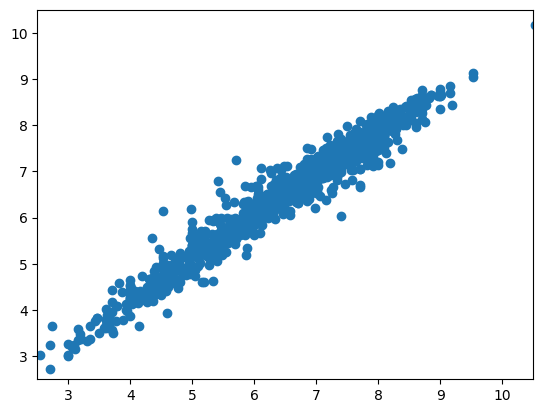

In [20]:
y_meas_train = transformers[0].untransform(train_dataset.y)
y_pred_train, y_pred_train_stds = predict_with_error(model, train_dataset.X, transformers[0])

plt.xlim([2.5, 10.5])
plt.ylim([2.5, 10.5])
plt.scatter(y_meas_train, y_pred_train)

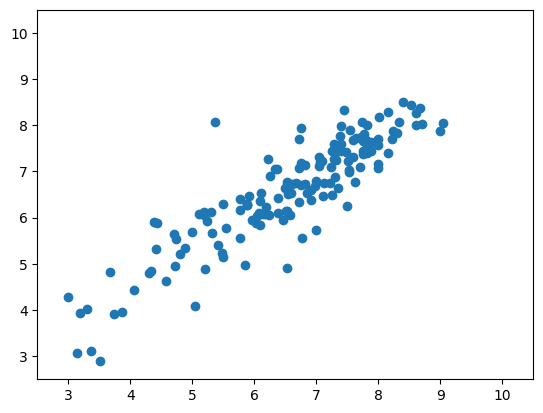

In [21]:
y_meas_test = transformers[0].untransform(test_dataset.y)
y_pred_test, y_pred_test_stds = predict_with_error(model, test_dataset.X, transformers[0])

plt.xlim([2.5, 10.5])
plt.ylim([2.5, 10.5])
plt.scatter(y_meas_test, y_pred_test)

In [22]:
def percent_within_std(y_meas, y_pred, y_std):
    assert len(y_meas) == len(y_pred) and len(y_meas) == len(y_std), 'length of y_meas and y_pred must be the same'

    count_within_error = 0
    for i in range(len(y_meas)):
        if abs(y_meas[i][0]-y_pred[i]) < y_std[i]:
            count_within_error += 1

    return count_within_error/len(y_meas)

In [23]:
percent_within_std(y_meas_train, y_pred_train, y_pred_train_stds)

0.9289256198347108

In [24]:
percent_within_std(y_meas_test, y_pred_test, y_pred_test_stds)

0.7828947368421053

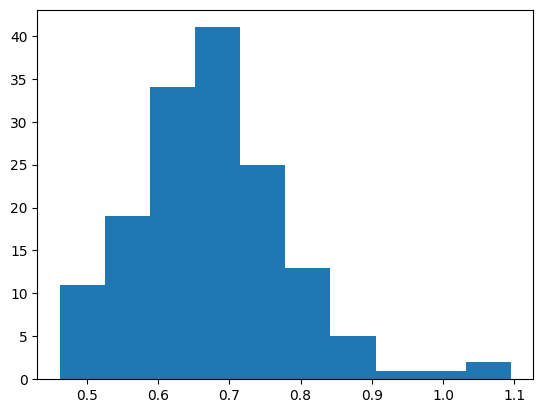

In [25]:
plt.hist(y_pred_test_stds)
plt.show()